# MNIST


In [0]:
# https://frenzy86.s3.eu-west-2.amazonaws.com/fav/test.csv
# https://frenzy86.s3.eu-west-2.amazonaws.com/fav/train.csv

In [4]:
import numpy as np 
import pandas as pd 

import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# plotly library
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
#from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

import os

Using TensorFlow backend.


In [0]:
img_rows, img_cols = 28, 28
np.random.seed(5)
#rn.seed(5)
#tf.set_random_seed(5)

In [0]:
#get_best_score for GridSearchCV¶
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_



In [0]:
# print Classification Report and Accuracy
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

In [0]:
# plot_confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [0]:
# plot_history_loss_and_acc
def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_keras_nn.history['acc'])
    axs[1].plot(history_keras_nn.history['val_acc'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

## Loading Data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
cd /content/drive/My Drive/Colab Notebooks/11_Deep_leaning

/content/drive/My Drive/Colab Notebooks/11_Deep_leaning


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
y = train["label"]
X = train.drop(["label"],axis = 1)
X_test = test

### Normalization

In [0]:
X = X/255.0
X_test = X_test/255.0

### Setting train and validation data


In [15]:
# for best performance, especially of the NN classfiers,
# set mode = "commit"
mode = "edit"
mode = "commit"
#

if mode == "edit" :
    nr_samples = 1200

if mode == "commit" :    
    nr_samples = 30000

y_train=y[:nr_samples]
X_train=X[:nr_samples]
start_ix_val = nr_samples 
end_ix_val = nr_samples + int(nr_samples/3)
y_val=y[start_ix_val:end_ix_val]
X_val=X[start_ix_val:end_ix_val]
    
print("nr_samples train data:", nr_samples)
print("start_ix_val:", start_ix_val)
print("end_ix_val:", end_ix_val)

nr_samples train data: 30000
start_ix_val: 30000
end_ix_val: 40000


## Part 1 : Exploring the Data

In [16]:
print("X:")
print(X.info())
print("*"*50)
print("X_test:")
print(X_test.info())
print("*"*50)
print("y:")
print(y.shape)

X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 251.2 MB
None
**************************************************
X_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 167.5 MB
None
**************************************************
y:
(42000,)


In [17]:
X.iloc[0:5,:]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y.iloc[0:5]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

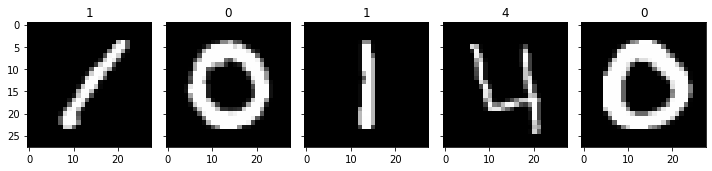

In [19]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[i].set_title(y[i])
plt.tight_layout()    

### Distribution of labels

In [20]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

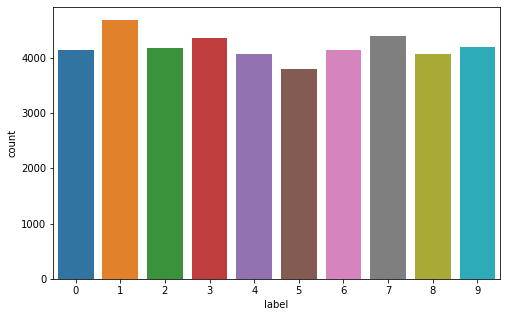

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.countplot(y)

#### get indexes of first 10 occurences for each number


In [0]:
li_idxs = []
for i in range(10):
    for nr in range(10):
        ix = y[y==nr].index[i]
        li_idxs.append(ix) 

#### first 10 image samples for each digit

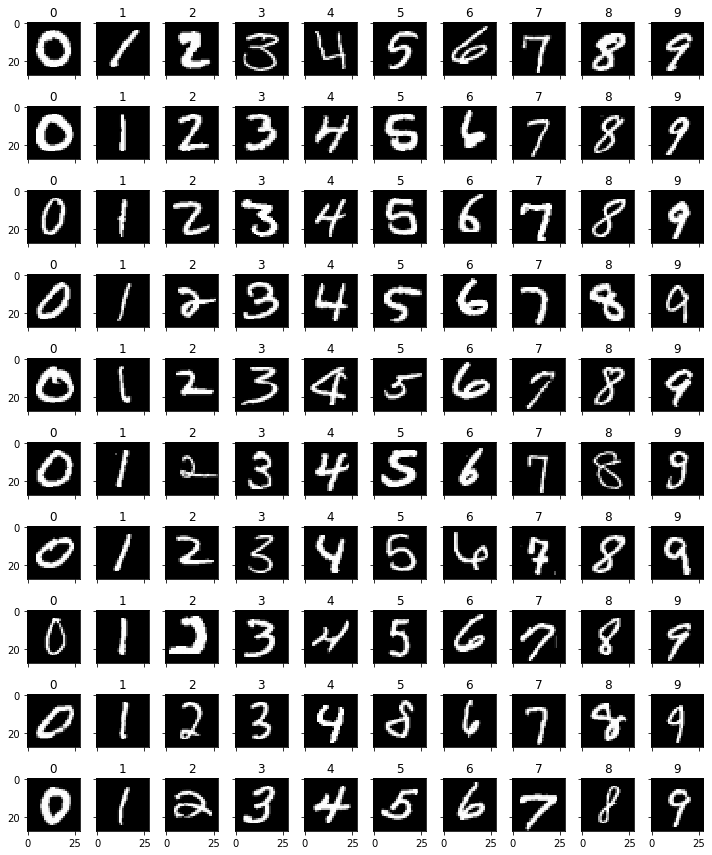

In [0]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for n, i in enumerate(li_idxs):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(y[i])
plt.tight_layout()    

### Part 2 : Sklearn Classifiers

In [0]:
# Perceptron

In [0]:
from sklearn.linear_model import Perceptron
clf_Perceptron = Perceptron(random_state=0)
param_grid = { 'penalty': ['l1','l2'], 'tol': [0.05, 0.1] }
GridCV_Perceptron = GridSearchCV(clf_Perceptron, param_grid, verbose=1, cv=5)
GridCV_Perceptron.fit(X_train,y_train)
score_grid_Perceptron = get_best_score(GridCV_Perceptron)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


0.8595
{'penalty': 'l1', 'tol': 0.05}
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l1', random_state=0, shuffle=True, tol=0.05,
           validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
pred_val_perc = GridCV_Perceptron.predict(X_val)

In [0]:
acc_perc = print_validation_report(y_val, pred_val_perc)


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       998
           1       0.91      0.95      0.93      1127
           2       0.91      0.86      0.88       967
           3       0.85      0.88      0.87      1060
           4       0.90      0.87      0.88       914
           5       0.84      0.83      0.84       914
           6       0.93      0.95      0.94       951
           7       0.84      0.93      0.88      1066
           8       0.78      0.82      0.80       995
           9       0.90      0.72      0.80      1008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy : 0.8787


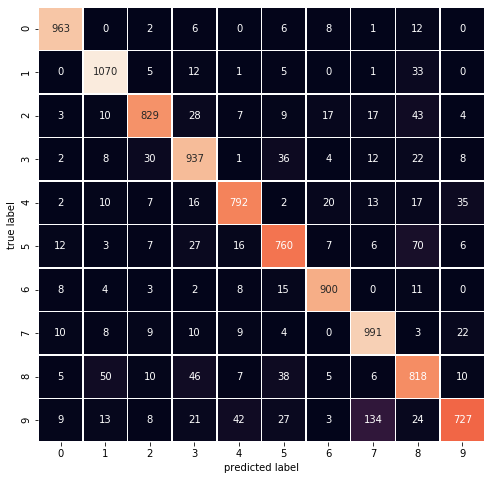

In [0]:
plot_confusion_matrix(y_val, pred_val_perc)

In [0]:
# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state=0)
param_grid = {'C': [0.014,0.012], 'multi_class': ['multinomial'],  
              'penalty': ['l1'],'solver': ['saga'], 'tol': [0.1] }
GridCV_LR = GridSearchCV(clf_LR, param_grid, verbose=1, cv=5)
GridCV_LR.fit(X_train,y_train)
score_grid_LR = get_best_score(GridCV_LR)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   52.1s finished


0.8721333333333334
{'C': 0.014, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1}
LogisticRegression(C=0.014, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)


In [0]:
pred_val_lr = GridCV_LR.predict(X_val)
acc_lr = print_validation_report(y_val, pred_val_lr)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       998
           1       0.88      0.98      0.93      1127
           2       0.89      0.87      0.88       967
           3       0.87      0.84      0.86      1060
           4       0.86      0.90      0.88       914
           5       0.84      0.79      0.82       914
           6       0.90      0.92      0.91       951
           7       0.90      0.89      0.89      1066
           8       0.89      0.80      0.84       995
           9       0.84      0.83      0.83      1008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy : 0.8789


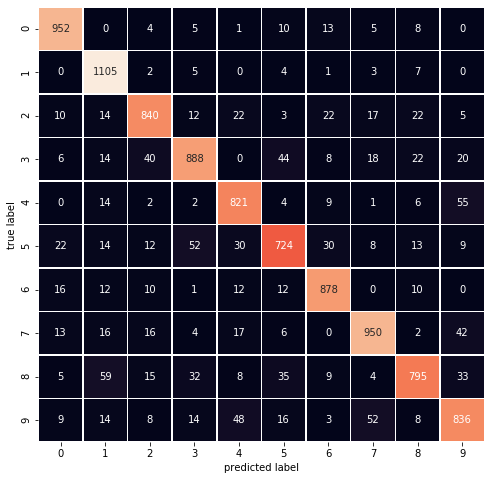

In [0]:
plot_confusion_matrix(y_val, pred_val_lr)

In [0]:
# KNN

Using GridSearchCV with KNN takes very long for this dataset.
Therefore I fit the data with one parameter: neighbors = 10
The resulting accuracy is already quite good.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
pred_val_knn = clf_knn.predict(X_val)
acc_knn = print_validation_report(y_val, pred_val_knn)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       998
           1       0.93      1.00      0.96      1127
           2       0.98      0.95      0.97       967
           3       0.97      0.96      0.97      1060
           4       0.98      0.96      0.97       914
           5       0.96      0.96      0.96       914
           6       0.97      0.99      0.98       951
           7       0.95      0.97      0.96      1066
           8       0.99      0.92      0.95       995
           9       0.95      0.94      0.94      1008

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9638


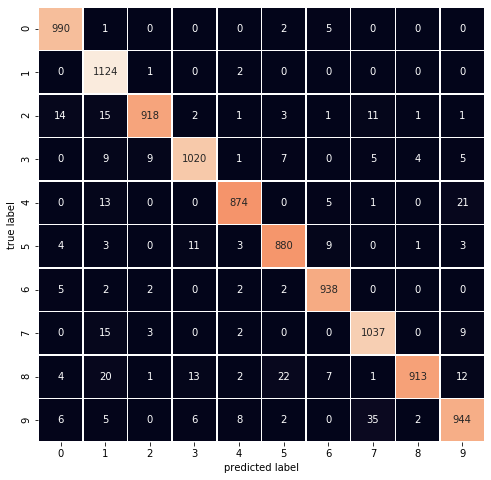

In [0]:
plot_confusion_matrix(y_val, pred_val_knn)

In [0]:
# Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(random_state=0)
param_grid = {'max_depth': [15], 'max_features': [100],  
              'min_samples_split': [5],'n_estimators' : [50] }
GridCV_RF = GridSearchCV(clf_RF, param_grid, verbose=1, cv=5)
GridCV_RF.fit(X_train,y_train)
score_grid_RF = get_best_score(GridCV_RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished


0.9545333333333333
{'max_depth': 15, 'max_features': 100, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [0]:
pred_val_rf = GridCV_RF.predict(X_val)

In [0]:
acc_rf = print_validation_report(y_val, pred_val_rf)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.95      0.97      0.96       967
           3       0.96      0.93      0.94      1060
           4       0.96      0.96      0.96       914
           5       0.97      0.96      0.96       914
           6       0.97      0.97      0.97       951
           7       0.96      0.96      0.96      1066
           8       0.95      0.95      0.95       995
           9       0.93      0.93      0.93      1008

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy : 0.9596


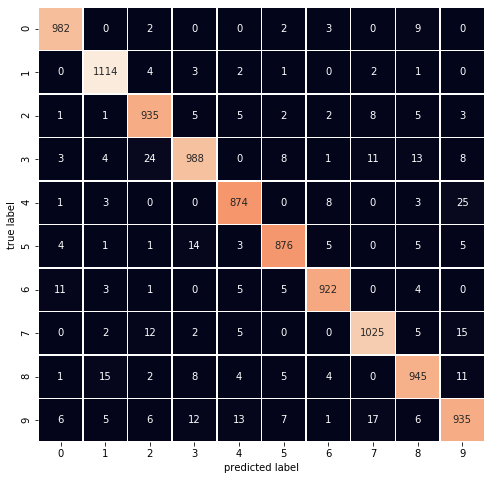

In [0]:
plot_confusion_matrix(y_val, pred_val_rf)


In [0]:
# Support Vector Machine Classifier

Like for KNN, GridSearchCV for SVM takes very long, so I only fit one good set of parameters here.


In [0]:
from sklearn.svm import SVC
clf_svm = SVC(C=5, gamma=0.05, kernel='rbf', random_state=0)
clf_svm.fit(X_train,y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
pred_val_svm = clf_svm.predict(X_val)
acc_svm = print_validation_report(y_val, pred_val_svm)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       998
           1       0.99      0.99      0.99      1127
           2       0.97      0.99      0.98       967
           3       0.98      0.97      0.98      1060
           4       0.98      0.97      0.98       914
           5       0.98      0.98      0.98       914
           6       0.99      0.99      0.99       951
           7       0.98      0.98      0.98      1066
           8       0.98      0.98      0.98       995
           9       0.98      0.96      0.97      1008

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy : 0.9808


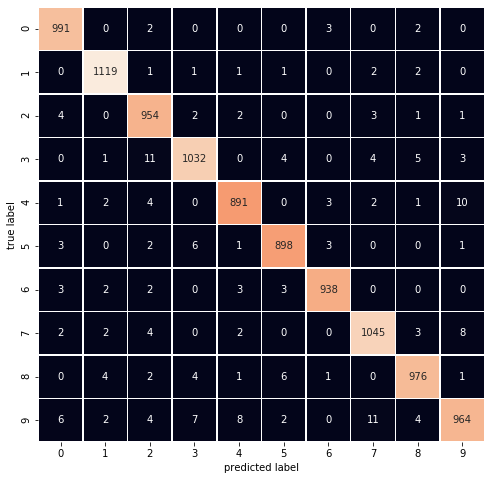

In [0]:
plot_confusion_matrix(y_val, pred_val_svm)

### Part 3: NN Classifiers with Keras

### 3.1.1 Keras: only input and output layer

In [0]:
y_train = to_categorical(y_train, 10)
y_val_10 = to_categorical(y_val, 10)

In [0]:
batchsize = int(nr_samples/15) 

dense layers : every node is connected to every other node in the next layer


In [0]:
def dense_model_0():
    model = Sequential()
    model.add(Dense(10, input_dim=784, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
model_dense_0 = dense_model_0()
model_dense_0.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_dense_0.fit(X_train, y_train, epochs=50, batch_size=batchsize)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





30000/30000 [==============================] - 11s 353us/step - loss: 2.0788 - acc: 0.2805
Epoch 2/50
30000/30000 [==============================] - 0s 13us/step - loss: 1.5350 - acc: 0.6696
Epoch 3/50
30000/30000 [==============================] - 0s 12us/step - loss: 1.1869 - acc: 0.7749
Epoch 4/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.9742 - acc: 0.8066
Epoch 5/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.8396 - acc: 0.8277
Epoch 6/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.7490 - acc: 0.8399
Epoch 7/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.6838 - acc: 0.8498
Epoch 8/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.6341 - acc: 0.8577
Epoch 9/50
30000/30000 [==============================] - 0s 12us/step - loss: 0.5952 - acc: 0.8

In [0]:
pred_val_dense0 = model_dense_0.predict_classes(X_val)

In [0]:
acc_fc0 = print_validation_report(y_val, pred_val_dense0)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       998
           1       0.93      0.98      0.96      1127
           2       0.91      0.89      0.90       967
           3       0.91      0.90      0.90      1060
           4       0.92      0.93      0.92       914
           5       0.91      0.85      0.88       914
           6       0.93      0.95      0.94       951
           7       0.93      0.92      0.93      1066
           8       0.88      0.88      0.88       995
           9       0.88      0.90      0.89      1008

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy : 0.9164


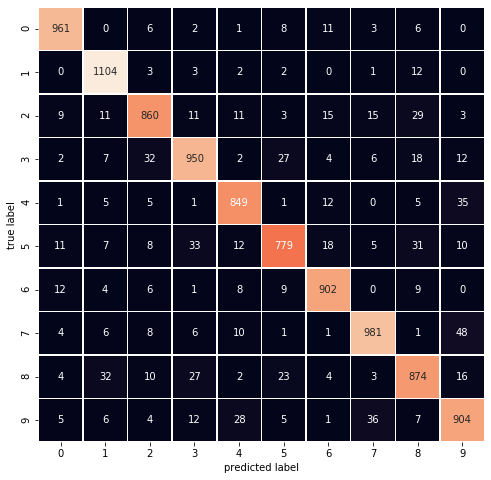

In [0]:
plot_confusion_matrix(y_val, pred_val_dense0)

#### Keras: 1 hidden layer

In [0]:
def dense_model_1():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
model_dense_1 = dense_model_1()
model_dense_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_dense_1 = model_dense_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Train on 30000 samples, validate on 10000 samples
Epoch 1/50
30000/30000 [==============================] - 1s 19us/step - loss: 1.6219 - acc: 0.5739 - val_loss: 0.9899 - val_acc: 0.7882
Epoch 2/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.7441 - acc: 0.8250 - val_loss: 0.5478 - val_acc: 0.8602
Epoch 3/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.4847 - acc: 0.8704 - val_loss: 0.4125 - val_acc: 0.8887
Epoch 4/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.3903 - acc: 0.8920 - val_loss: 0.3512 - val_acc: 0.9017
Epoch 5/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.3418 - acc: 0.9061 - val_loss: 0.3153 - val_acc: 0.9118
Epoch 6/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.3105 - acc: 0.9148 - val_loss: 0.2904 - val_acc: 0.9196
Epoch 7/50
30000/30000 [==============================] - 0s 13us/step - loss: 0.2877 - acc: 0.9203 - val_loss: 0.2713 - val_acc

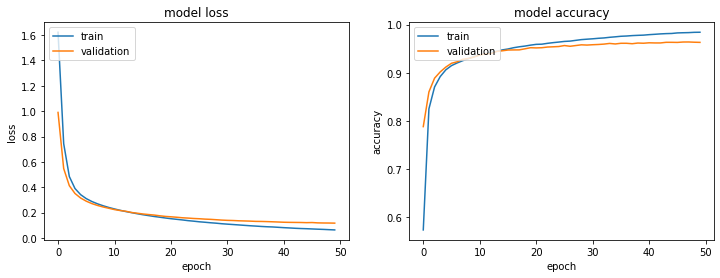

In [0]:
plot_history_loss_and_acc(history_dense_1)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.96      0.97      0.96       967
           3       0.97      0.95      0.96      1060
           4       0.96      0.95      0.96       914
           5       0.95      0.96      0.96       914
           6       0.96      0.97      0.97       951
           7       0.96      0.98      0.97      1066
           8       0.96      0.96      0.96       995
           9       0.95      0.92      0.94      1008

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

0.963


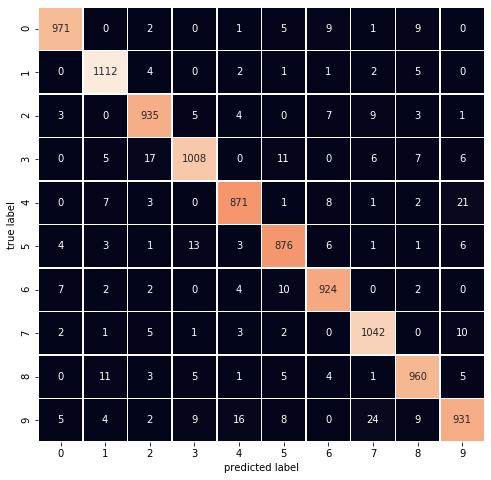

In [0]:
pred_val_dense1 = model_dense_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense1)
print(classification_report(y_val, pred_val_dense1))
acc_fc1 = accuracy_score(y_val, pred_val_dense1)
print(acc_fc1)

#### Keras: 2 hidden layers

In [0]:
def dense_model_2():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
model_dense_2 = dense_model_2()
model_dense_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_dense_2 = model_dense_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                    epochs=50, batch_size=batchsize)

Train on 30000 samples, validate on 10000 samples
Epoch 1/50
30000/30000 [==============================] - 1s 22us/step - loss: 1.6258 - acc: 0.6089 - val_loss: 0.8633 - val_acc: 0.8014
Epoch 2/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.5863 - acc: 0.8478 - val_loss: 0.4075 - val_acc: 0.8860
Epoch 3/50
30000/30000 [==============================] - 0s 15us/step - loss: 0.3701 - acc: 0.8933 - val_loss: 0.3141 - val_acc: 0.9093
Epoch 4/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.3059 - acc: 0.9121 - val_loss: 0.2736 - val_acc: 0.9210
Epoch 5/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.2676 - acc: 0.9224 - val_loss: 0.2503 - val_acc: 0.9269
Epoch 6/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.2408 - acc: 0.9317 - val_loss: 0.2302 - val_acc: 0.9335
Epoch 7/50
30000/30000 [==============================] - 0s 14us/step - loss: 0.2219 - acc: 0.9364 - val_loss: 0.2179 - val_acc

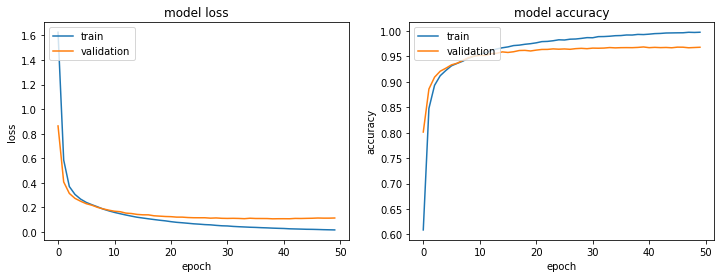

In [0]:
plot_history_loss_and_acc(history_dense_2)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       998
           1       0.97      0.99      0.98      1127
           2       0.98      0.97      0.97       967
           3       0.96      0.96      0.96      1060
           4       0.96      0.97      0.97       914
           5       0.97      0.96      0.96       914
           6       0.97      0.98      0.98       951
           7       0.96      0.98      0.97      1066
           8       0.96      0.96      0.96       995
           9       0.96      0.93      0.94      1008

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.9681


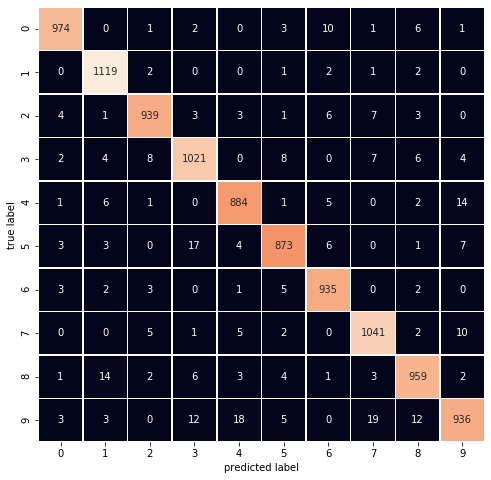

In [0]:
pred_val_dense2 = model_dense_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_dense2)
print(classification_report(y_val, pred_val_dense2))
acc_fc2 = accuracy_score(y_val, pred_val_dense2)
print(acc_fc2)

## Keras : Convolutional Neural Networks, CNN

features : reshaping 1d vector to 2d images (784) --> (28,28,1)

In [0]:
X_train.shape


(30000, 784)

In [0]:
X_train = X_train.values.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.values.reshape(X_val.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [0]:
X_train.shape


(30000, 28, 28, 1)

Keras: CNN model 1
* Conv2D (32, (3, 3))
* Conv2D (64, (3, 3))
* Pooling2D (2,2)
* Dropout (0.25) Flatten
* Dense(128, relu)
* Dropout (0.5)
* Dense(10, softmax)

In [0]:
batchsize = 128
epochs = 12

In [0]:
activation = 'relu'
adadelta = Adadelta()
loss = categorical_crossentropy

In [0]:
def cnn_model_1(activation):
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape)) 
    
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())

    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=loss, optimizer=adadelta, metrics=['accuracy'])

    return model

In [0]:
model_cnn_1 = cnn_model_1(activation)
model_cnn_1.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
___

In [0]:
#model_cnn_1.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, verbose=1)
history_cnn_1 = model_cnn_1.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                   epochs=epochs, batch_size=batchsize, verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/12
30000/30000 [==============================] - 9s 292us/step - loss: 0.4140 - acc: 0.8709 - val_loss: 0.1028 - val_acc: 0.9697
Epoch 2/12
30000/30000 [==============================] - 3s 96us/step - loss: 0.1265 - acc: 0.9629 - val_loss: 0.0695 - val_acc: 0.9775
Epoch 3/12
30000/30000 [==============================] - 3s 97us/step - loss: 0.0898 - acc: 0.9729 - val_loss: 0.0580 - val_acc: 0.9826
Epoch 4/12
30000/30000 [==============================] - 3s 97us/step - loss: 0.0708 - acc: 0.9796 - val_loss: 0.0512 - val_acc: 0.9853
Epoch 5/12
30000/30000 [==============================] - 3s 97us/step - loss: 0.0611 - acc: 0.9803 - val_loss: 0.0412 - val_acc: 0.9880
Epoch 6/12
30000/30000 [==============================] - 3s 98us/step - loss: 0.0502 - acc: 0.9846 - val_loss: 0.0458 - val_acc: 0.9875
Epoch 7/12
30000/30000 [==============================] - 3s 96us/step - loss: 0.0451 - acc: 0.9862 - val_loss: 0.0408 - val_ac

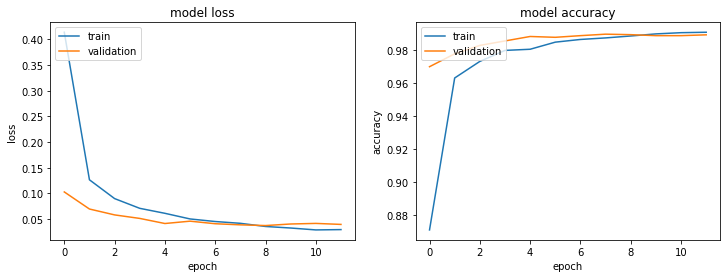

In [0]:
plot_history_loss_and_acc(history_cnn_1)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       998
           1       0.99      1.00      0.99      1127
           2       0.98      0.99      0.99       967
           3       0.99      0.99      0.99      1060
           4       0.99      0.98      0.98       914
           5       0.99      0.99      0.99       914
           6       0.99      0.99      0.99       951
           7       0.98      0.99      0.99      1066
           8       0.99      0.99      0.99       995
           9       0.98      0.97      0.98      1008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

0.989


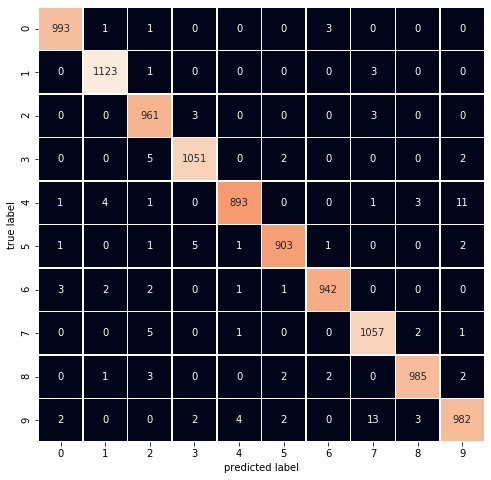

In [0]:
pred_val_cnn1 = model_cnn_1.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn1)
print(classification_report(y_val, pred_val_cnn1))
acc_cnn1 = accuracy_score(y_val, pred_val_cnn1)
print(acc_cnn1)

Keras: CNN model 2
* Conv2D (32, (3, 3))
* Pooling2D (2,2)
* Conv2D (32, (3, 3))
* Pooling2D (2,2)
* Flatten
* Dense(256, relu)
* Dense(10, softmax)

In [0]:
batch_size=64
epochs=30

In [0]:
def cnn_model_2(optimizer,loss):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'Same', activation="relu", input_shape=input_shape ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation=activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy']) 

    return model

In [0]:
model_cnn_2 = cnn_model_2(adadelta, categorical_crossentropy)
model_cnn_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               295168    
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [0]:
#model_cnn_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
history_cnn_2 = model_cnn_2.fit(X_train, y_train, validation_data=(X_val,y_val_10), 
                                epochs=epochs, batch_size=batchsize, verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/30
30000/30000 [==============================] - 2s 80us/step - loss: 0.3567 - acc: 0.8890 - val_loss: 0.0885 - val_acc: 0.9724
Epoch 2/30
30000/30000 [==============================] - 2s 57us/step - loss: 0.0803 - acc: 0.9759 - val_loss: 0.0648 - val_acc: 0.9809
Epoch 3/30
30000/30000 [==============================] - 2s 60us/step - loss: 0.0519 - acc: 0.9845 - val_loss: 0.0537 - val_acc: 0.9848
Epoch 4/30
30000/30000 [==============================] - 2s 64us/step - loss: 0.0392 - acc: 0.9874 - val_loss: 0.0492 - val_acc: 0.9853
Epoch 5/30
30000/30000 [==============================] - 2s 61us/step - loss: 0.0297 - acc: 0.9910 - val_loss: 0.0460 - val_acc: 0.9863
Epoch 6/30
30000/30000 [==============================] - 2s 63us/step - loss: 0.0219 - acc: 0.9927 - val_loss: 0.0573 - val_acc: 0.9832
Epoch 7/30
30000/30000 [==============================] - 2s 63us/step - loss: 0.0186 - acc: 0.9946 - val_loss: 0.0426 - val_acc

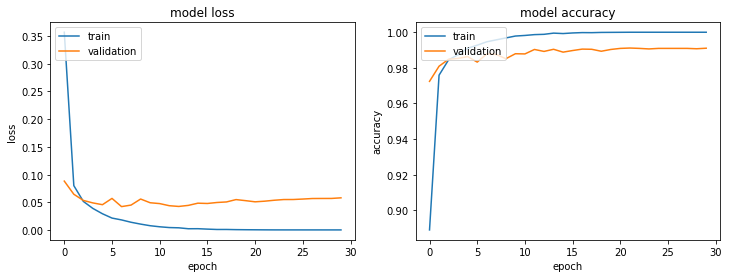

In [0]:
plot_history_loss_and_acc(history_cnn_2)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       998
           1       0.99      1.00      0.99      1127
           2       0.99      0.99      0.99       967
           3       1.00      0.99      0.99      1060
           4       0.99      0.99      0.99       914
           5       0.99      0.99      0.99       914
           6       1.00      0.99      0.99       951
           7       0.99      0.99      0.99      1066
           8       0.99      0.99      0.99       995
           9       0.98      0.98      0.98      1008

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

0.991


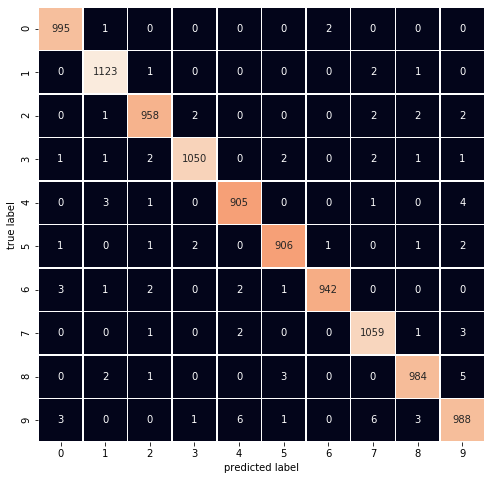

In [0]:
pred_val_cnn2 = model_cnn_2.predict_classes(X_val)
plot_confusion_matrix(y_val, pred_val_cnn2)
print(classification_report(y_val, pred_val_cnn2))
acc_cnn2 = accuracy_score(y_val, pred_val_cnn2)
print(acc_cnn2)